### Import Libraries

In [1]:
# WindowsのMKL版 KMeansのmemory leak関連のバグを防ぐ
# (参照: cs3-06-04「クラスタリングと散布図」)
import os
os.environ['OMP_NUM_THREADS'] = '1'

# 数値計算を高速に行うライブラリ Numpy
import numpy as np

# 2次元の表形式のデータの扱いに便利なライブラリ Pandas
import pandas as pd

# グラフ描画に便利なライブラリ Matplotlib
import matplotlib.pyplot as plt

# KMeans法(クラスタリング)
from sklearn.cluster import KMeans

# データの標準化
from sklearn.preprocessing import scale

# 相関
import seaborn as sns

# 回帰
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

## 配列
#### [Numpy] ndarray (numpy配列)
##### np.array 関数
- Pythonのリストから ndarray を作れる

#### [Pandas] DataFrame / Series
- 表形式の ndarray を扱うのに便利なクラス DataFrame
##### pd.DataFrame 関数
- Pythonのリストから DataFrameを作る

##### df.to_numpy() 関数
- dfからindexとcolumnsを除いたndarrayに変換

##### (DataFrame, Series, ndarray は Pythonのlistと同様にミュータブルであるため、単に代入するだけだと別名が付くだけで実体は同じになってしまう。これを対策するために、複製する際は .copy() メソッドを使うこと。)

In [2]:
## list
lst = [0, 1, 2]

print(lst)
print(type(lst))
print("----------")

## ndarray
nd = np.array(lst) 

print(nd)
print(type(nd))
print("----------")

## DataFrame
df = pd.DataFrame([lst, [3, 4, 5]])
df.index = ['r0', 'r1']
df.columns = ['c0', 'c1', 'c2']

display(df)
print(type(df))
print("----------")


nd2 = df.to_numpy()
print(nd2)
print(type(nd2))

[0, 1, 2]
<class 'list'>
----------
[0 1 2]
<class 'numpy.ndarray'>
----------


,c0,c1,c2
r0,0,1,2
r1,3,4,5


<class 'pandas.core.frame.DataFrame'>
----------
[[0 1 2]
 [3 4 5]]
<class 'numpy.ndarray'>


## データの表示
- ##### .shape
  - 各軸の要素数の表示,  (ndarray可)
- ##### .info()
  - 各Columnのカウントやデータ型などの一覧表示,  
- ##### display(df)
  - df の表示, (ndarrayにも使えるが...。 )
- ##### .head(n), .tail(n)
  - 前から n 行, 後ろから n 行の抜き出し, nを指定しない場合はn=5,  
- ##### df.index
  - indexの表示 (あまり使わない？)
- ##### df.columns
  - columnsの表示 (そこそこ使う？)

In [3]:
# ndarray
print(nd.shape)
display(nd)
print("----------")

# DataFrame
print( df.shape, "=(行, 列)")
print(df.info())
display(df)
display(df.head(1))
df_index = df.index
print(df_index)
df_columns = df.columns
print(df_columns)

(3,)


array([0, 1, 2])

----------
(2, 3) =(行, 列)
<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, r0 to r1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c0      2 non-null      int64
 1   c1      2 non-null      int64
 2   c2      2 non-null      int64
dtypes: int64(3)
memory usage: 64.0+ bytes
None


,c0,c1,c2
r0,0,1,2
r1,3,4,5


,c0,c1,c2
r0,0,1,2


Index(['r0', 'r1'], dtype='object')
Index(['c0', 'c1', 'c2'], dtype='object')


### データの読み込み
#### [Pandas] read_csv 関数　(下記はデフォルト値)
- pd.read_csv(path, sep=',', skiprows=0, header=0, encoding='utf-8') 
- sep: 区切り文字　(省略可)
  - tab区切り -> '\t'
  - (可変個数の)空白文字 -> '\s+'
  - セミコロン(;)区切り　->　';'
- skiprows: 先頭から読み飛ばす行数　(省略可)
- header: 読み飛ばした上で列ラベルをどの行にするか？　(省略可)
  - 列ラベルがないとき -> None
- encoding: 文字コードを指定　(省略可)
  - vscodeで開き、画面下の文字コードが書かれているところをクリック
  - エンコード付きで再度開くをクリック
  - 文字化けしないものを探す
    - Shift JIS -> 'shift-jis'
    - EUC-JP -> 'euc-jp'

In [4]:
# 下準備
data = [["2004/4/1", "Satoshi", 2000, 10000], ["2004/5/10", "Nakamoto", 3000, 20000], ["2004/6/20", "Haruki", 4000, 30000]]
df = pd.DataFrame(data, columns = ["Data", "Name", "Money", "balance"])
df.to_csv("data/matome.csv", index=False)

# データの読み込み
df1 = pd.read_csv("data/matome.csv")
print(df1.shape)
print(df1.info())
display(df1)

(3, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     3 non-null      object
 1   Name     3 non-null      object
 2   Money    3 non-null      int64 
 3   balance  3 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 224.0+ bytes
None


,Data,Name,Money,balance
0,2004/4/1,Satoshi,2000,10000
1,2004/5/10,Nakamoto,3000,20000
2,2004/6/20,Haruki,4000,30000


### 要素の取り出し
- ##### df[column]
  - (ex) df['col1']
  - dfの一列分のデータを取り出すことができる
  - 取りだした列のデータ型は "Series"

- ##### df[[columns]]
  - (ex) df[['col1', 'col3']]
  - 複数列取りだすことができる
  - 取り出したもののデータ型は "DataFrame"

- ##### df.loc[行スライス, 列スライス]
  - (ex) df.loc[1:3, 'col1':'col3']
  - ある範囲の列をまとめて取り出す
  - [先頭行の行番号:末尾列の行番号, 先頭列の列ラベル:末尾列の列ラベル] のように指定する
- ##### df.iloc[行スライス, 列スライス]
  - (ex) df.iloc[1:4, 0:3]
  - ある範囲の列をまとめて取り出す
  - 列ラベルではなく列番号を用いるときに使う
  - [先頭行の行番号:末尾列の行番号+1, 先頭列の列番号:末尾列の列番号+1] のように指定する

- ##### df.at[行番号, 列ラベル]
  - 要素の一つの値を取り出すことができる
  - df.at[~] = ~ のように記述することで書き換えも可能

- ##### df.iat[行スライス, 列スライス]
  - (ex) df.iat[1, 0]
  - 要素1つの値を取り出す
  - df.iat[~] = ~ のように記述することで書き換えも可能

In [5]:
df_Series = df1["Name"]
print(df_Series)
print(type(df_Series))
print("--------")

df_DataFrame = df1[["Name", "Money"]]
display(df_DataFrame)
print(type(df_DataFrame))
df_DataFrame2 = df1[["Data", "Money"]]
display(df_DataFrame2)
print("--------")

# 先頭から 1行目まで、Name列から末尾まで
df_loc = df1.loc[:1,"Name":] 
display(df_loc)

df_iloc = df1.iloc[:2, 1:]
display(df_iloc)
print("--------")


df_at = df1.at[0, "Money"]
print(df_at)

df_iat = df1.iat[0, 2]
print(df_iat)
print("--------")

df.at[0, "Money"] = 10000
display(df1)

df.iat[0, 2] = 6000
display(df1)

0     Satoshi
1    Nakamoto
2      Haruki
Name: Name, dtype: object
<class 'pandas.core.series.Series'>
--------


,Name,Money
0,Satoshi,2000
1,Nakamoto,3000
2,Haruki,4000


<class 'pandas.core.frame.DataFrame'>


,Data,Money
0,2004/4/1,2000
1,2004/5/10,3000
2,2004/6/20,4000


--------


,Name,Money,balance
0,Satoshi,2000,10000
1,Nakamoto,3000,20000


,Name,Money,balance
0,Satoshi,2000,10000
1,Nakamoto,3000,20000


--------
2000
2000
--------


,Data,Name,Money,balance
0,2004/4/1,Satoshi,2000,10000
1,2004/5/10,Nakamoto,3000,20000
2,2004/6/20,Haruki,4000,30000


,Data,Name,Money,balance
0,2004/4/1,Satoshi,2000,10000
1,2004/5/10,Nakamoto,3000,20000
2,2004/6/20,Haruki,4000,30000


### データの把握、基本統計量
- ##### [Series] .value_counts()
  - (ex) df['col1'].value_counts()
  -  カテゴリー変数の値と頻度を取得する
- ##### [DataFrame] 統計用関数
  - (ex) df[:, 'col2':].max(axis=0, numeric_only=True)
  - 指定した範囲の指定した軸について、それぞれの統計用関数の結果を返す
  - 統計用関数一覧 (Pandas):
    - sum(): 総和
    - min(): 最小値
    - max(): 最大値
    - mean(): 平均値
    - median(): 中央値
    - var(): 分散 # 母分散は var(ddof=0) 
    - std(): 標準偏差 # 母標準偏差は std(ddof=0)
    - etc...
  - 統計用関数一覧 (numpy):
    - amin(): 最小値
    - amax(): 最大値
    - var(): 分散　# 不偏分散はvar(ddof=1)
    - std(): 標準偏差 # 不偏標準偏差は std(ddof=1)
    - etc... (記載していないものはpandasと同じ。)
  - axis: 軸を指定する。0はindex軸, 1はcolumns軸
  - numeric_only: 数値データのみを参照する
- ##### [DataFrame] .describe()
  - 各数値列のデータの範囲やカテゴリー変数列の値の種類数などをまとめて表示

In [6]:
# 準備
df1.loc[3] = ["2004/7/30", "Satoshi", 5000, 40000]

# .value_counts()
print(df1["Name"].value_counts())
print("------")

# 統計用関数
print(df1.max(axis=0, numeric_only=True))
print(df1["Money"].max())
print(np.max(df1["Money"]))

#  .describe()
display(df1.describe())


Name
Satoshi     2
Nakamoto    1
Haruki      1
Name: count, dtype: int64
------
Money       5000
balance    40000
dtype: int64
5000
5000


,Money,balance
count,4.000000,4.000000
mean,3500.000000,25000.000000
std,1290.994449,12909.944487
min,2000.000000,10000.000000
25%,2750.000000,17500.000000
50%,3500.000000,25000.000000
75%,4250.000000,32500.000000
max,5000.000000,40000.000000


### データ型の変更・表示
- ##### [Series] .dtype()
  - データ型を表示
- ##### [Series] .astype()
  - データ型を変更

int, float, str などのデータ型が頻出

In [7]:
display(df1.info())
df1["Money"]=df1["Money"].astype("float")
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     4 non-null      object
 1   Name     4 non-null      object
 2   Money    4 non-null      int64 
 3   balance  4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 160.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Data     4 non-null      object 
 1   Name     4 non-null      object 
 2   Money    4 non-null      float64
 3   balance  4 non-null      int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 160.0+ bytes


None

### データの可視化
- ##### 基本的な使い方
  - 表示関数 → 装飾用関数 → plt.show() のように記述する
  - 装飾用関数の例
    - plt.title(タイトル)
    - plt.xlabel() / ylabel(): 軸ラベル
    - plt.xticks() / yticks(): 目盛ラベル
      - plt.xticks(rotation=n): n度回転
    - plt.xlim() / ylim(): 描画範囲
    - plt.legend(): 凡例
    - plt.show(): 表示
  - 日本語を使いたい？
    - plt.rcParams['font.family'] = 'Yu Mincho'
- ##### 箱ひげ図(boxplot)
  - plt.boxplot(データ)
- ##### ヒストグラム(hist)
  - plt.hist(データ, bins=n)
- ##### グラフ(plot)
  - plt.plot(x軸データ, y軸データ, [フォーマット文字列], オプション)
  - フォーマット文字列: マーカー/線/色 の順
    - [マーカー] 'o': 丸, 's': 四角, 'x', ×, '.': 点
    - [線] '-': 実線, '--': 破線, ':': 点線
    - [色] 'r': 赤, 'g': 緑, 'y': 黄
  - これらを "o-r" のように組み合わせて使う。
  - オプション例:
    - linewidth: 線の太さの指定
- ##### 散布図(scatter)
  - plt.scatter(x軸データ, y軸データ, オプション)
  - オプション例:
    - marker: 'マーカー指定'
    - s: マーカーのサイズ (float)
    - color: 'マーカーの色' ('red', 'blue', ...)
    - alpha: 透明度 (float 0 <= n <= 1)

### データの加工
- ##### [DataFrame] 列間の演算
  - (ex) ser = 2 * df['col1'] + df['col2'] - 100
  - 列の数値をまとめて計算できる。
- ##### [DataFrame] 列の追加
  - (ex) df['col_new'] = ser
  - 存在しないcolumnsを指定することで
  - 列を追加することができます
- ##### [DataFrame] 列・行の削除
  - (ex) df.drop(columns=['col_new'])
  - (ex) df.drop(index=[10, 11])
  - 指定した列・行を削除します。
  - df = df.drop() のようにしないと
  - 変更が保持されないので注意
- ##### [DataFrame] データの取り出し
  - (ex) df[df['col1'] < 100]
  - df[ 条件 ] で指定できる。
  - 条件:
    - df[column].str.match(r'正規表現') # 正規表現にマッチする行
    - df[column].isin([値1, 値2...]) # 列の値が[]に含まれるもの
  - 複数の条件を指定したい場合は以下のように記述する。
    - (条件1) & (条件2): かつ(and)
    - (条件1) | (条件2): または(or)
  - 条件を満たさないとき にしたいときは、~(条件) のように記述する。
- ##### [DataFrame] 行番号のリセット
  - df.reset_index(drop=True)
  - 不連続になった列番号を0から始まる連番に直す
  - index列としてもとの行番号が追加されるため、不要な場合は drop = True オプションを指定する
- ##### [DataFrame] 列のソート
  - df.sort_values(by=column, ascending=True)
  - dfの各行を、column列の値の昇順(または降順)にソート
  - ascending: True は 昇順 / Falseは 降順
- ##### [Series] 最大値・最小値の行番号の取得
  - df[column].idxmax() / .idxmin()
  - column列の値が列で最大 / 最小となるようなindexを返す
- ##### [DataFrame] データフレームのマージ
  - **pd**.merge(左df、右df、how='マージ方式', left_on='左dfのcolumn名', right_on='右dfのcolumn名')
  - how:
    - left(左外結合), right(右外結合), outer(完全外結合), inner(内結合), cross(直積)
- ##### [DataFrame] 列の順序変更
  - df.columns と ~.insert() を併用するのが効率的。
  - ~.insert(index, value)
  - listのindex番目にvalueを代入する、という構文

In [8]:
display(df1)

# 列間の演算
SUM = df1["Money"] + df1["balance"]
print("-------")
# 列の追加
df1["all"] = SUM
display(df1)
print("-------")

# 列・行の削除
df2 = df1.drop(index=2, columns=["Data", "Name"])
display(df2)
display(df2.reset_index(drop=True))
print("-------")

# 列のソート
display(df1.sort_values(by="all", ascending=False))
print("-------")

# マージ
df_a = pd.DataFrame([[11, "satoshi"], [12, "Nakamoto"], [13, None], [14, "Haruki"], [15, "futaba"]], columns=["ID", "Name"])
df_b = pd.DataFrame([[11, 50], [12, None], [13, 20], [14, 19], [16, 30]], columns=["ID", "age"])

print("完全外結合")
df_merge3 = pd.merge(df_a, df_b, how="outer", left_on="ID", right_on="ID")
display(df_merge3)
print("左結合")
df_merge = pd.merge(df_a, df_b, how="left", left_on="ID", right_on="ID")
display(df_merge)
print("右結合")
df_merge2 = pd.merge(df_a, df_b, how="right", left_on="ID", right_on="ID")
display(df_merge2)
print("内結合")
df_merge3 = pd.merge(df_a, df_b, how="inner", on="ID")
display(df_merge3)
print("-------")

# 列の順序変更
cols = list(df1.columns)[:-1]
cols.insert(2, "all")
df1 = df1[cols]
display(df1)

,Data,Name,Money,balance
0,2004/4/1,Satoshi,2000.0,10000
1,2004/5/10,Nakamoto,3000.0,20000
2,2004/6/20,Haruki,4000.0,30000
3,2004/7/30,Satoshi,5000.0,40000


-------


,Data,Name,Money,balance,all
0,2004/4/1,Satoshi,2000.0,10000,12000.0
1,2004/5/10,Nakamoto,3000.0,20000,23000.0
2,2004/6/20,Haruki,4000.0,30000,34000.0
3,2004/7/30,Satoshi,5000.0,40000,45000.0


-------


,Money,balance,all
0,2000.0,10000,12000.0
1,3000.0,20000,23000.0
3,5000.0,40000,45000.0


,Money,balance,all
0,2000.0,10000,12000.0
1,3000.0,20000,23000.0
2,5000.0,40000,45000.0


-------


,Data,Name,Money,balance,all
3,2004/7/30,Satoshi,5000.0,40000,45000.0
2,2004/6/20,Haruki,4000.0,30000,34000.0
1,2004/5/10,Nakamoto,3000.0,20000,23000.0
0,2004/4/1,Satoshi,2000.0,10000,12000.0


-------
完全外結合


,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,13,None,20.0
3,14,Haruki,19.0
4,15,futaba,NaN
5,16,NaN,30.0


左結合


,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,13,None,20.0
3,14,Haruki,19.0
4,15,futaba,NaN


右結合


,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,13,None,20.0
3,14,Haruki,19.0
4,16,NaN,30.0


内結合


,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,13,None,20.0
3,14,Haruki,19.0


-------


,Data,Name,all,Money,balance
0,2004/4/1,Satoshi,12000.0,2000.0,10000
1,2004/5/10,Nakamoto,23000.0,3000.0,20000
2,2004/6/20,Haruki,34000.0,4000.0,30000
3,2004/7/30,Satoshi,45000.0,5000.0,40000


### データのクレンジング
- ##### [DataFrame] 重複列の検出
  - df.duplicated()
- ##### [DataFrame] 重複列の削除
  - df.drop_duplicates()
  - 列番号が不連続になってしまうため、必要ならreset_indexと併用する
- ##### [DataFrame] 欠損値の確認
  - df.isna()
  - 個数を数えたいときには？
    - df.isna().sum()
    - .isna() は欠損値に対してTrue (=数値の1)を返すため、sum()で合計を取ると個数を得ることができる。
  - 欠損値を含む行を表示するには？
    - df[df.isna().any(axis=1)]
    - 行方向(axis=1)に検索して、一つでも欠損値があれば(any)その行についてTrue
    - Trueになっている行をdf[~]で表示
- ##### [DataFrame] 欠損値の補完
  - df.fillna(~)
  - 各列の平均で欠損値を埋めたいとき
    - mu = df.mean(numeric_only=True)
    - df_filled = df.fillna(mu)
    - このように記述するとよい。もちろん、列ごとに指定した値で置換することも可能。
- ##### [DataFrame] 欠損値の削除
  - df.dropna(): 一つでも欠損値を含む行を削除
  - df.dropna(axis=1) 一つでも欠損値を含む列を削除
  - df.dropna(how='all'): すべての値が欠損値の行を削除
- ##### [Series] 要素の値の置換
  - df[column].replace(old, new)
  - df[column].replace([old1, old2], new)
  - df[column].replace({old1: new1, old2: new2})
  - value.counts()と併用して表記ゆれを修正するために用いることが多い。
  - データ型を変換したいときには？
    - df[column].replace({old1: new1, old2: new2}).astype('int')
    - 明示的にint型を指定してあげればよい。
  - 条件によって置換する数値を変えたいときには？
    - lambda式を使う。
      - def ~(arg1, arg2):
      - [tab] return arg1 + arg2
    - と、
      - lambda arg1, arg2: arg1 + arg2
    - は同じ意味である。
    - これと .map メソッドを用いて、
    - df[column].map(lambda x: 10000 if x > 10000 else x)
    - のように書くことができる。
    - (ここでは三項演算子(a if 条件式 else b) を使っ手記述している)
- ##### [DataFrame] データの保存
  - df.to_csv(path, index=bool, encoding="")
  - index: Trueにつると行番号が追加される
  - encoding: 文字コードの指定

In [9]:
# 準備
df_c = pd.DataFrame([[11, "satoshi"], [12, "Nakamoto"],[12, "Nakamoto"], [13, ], [14, "Haruki"], [15, "futaba"]], columns=["ID", "Name"])
df_d = pd.DataFrame([[11, 50], [12, None],[13, 20], [14, 19], [16, 30]], columns=["ID", "age"])
df_merge4 = pd.merge(df_c, df_d, how="outer", left_on="ID", right_on="ID")
display(df_merge4)

# 重複列の検出
display(df_merge4[df_merge4.duplicated(keep=False)])

# 重複列の削除
df_merge4 = df_merge4.drop_duplicates().reset_index(drop=True)
display(df_merge4)

# 欠損値の確認
print(df_merge4.isna().sum())
display(df_merge4[df_merge4.isna().any(axis=1)])

# 欠損値の補完
mu = df_merge4.mean(numeric_only=True)
df_merge4 = df_merge4.fillna(mu)
display(df_merge4)

# 欠損値の削除
df_merge5 = df_merge4.dropna()
display(df_merge5)
df_merge5 = df_merge5.reset_index(drop=True)
display(df_merge5)

#  要素の値の置換
df_merge5["Name"] = df_merge5["Name"].replace(["satoshi"], "Satoshi")
display(df_merge5)

,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,12,Nakamoto,NaN
3,13,None,20.0
4,14,Haruki,19.0
5,15,futaba,NaN
6,16,NaN,30.0


,ID,Name,age
1,12,Nakamoto,NaN
2,12,Nakamoto,NaN


,ID,Name,age
0,11,satoshi,50.0
1,12,Nakamoto,NaN
2,13,None,20.0
3,14,Haruki,19.0
4,15,futaba,NaN
5,16,NaN,30.0


ID      0
Name    2
age     2
dtype: int64


,ID,Name,age
1,12,Nakamoto,NaN
2,13,None,20.0
4,15,futaba,NaN
5,16,NaN,30.0


,ID,Name,age
0,11,satoshi,50.00
1,12,Nakamoto,29.75
2,13,None,20.00
3,14,Haruki,19.00
4,15,futaba,29.75
5,16,NaN,30.00


,ID,Name,age
0,11,satoshi,50.00
1,12,Nakamoto,29.75
3,14,Haruki,19.00
4,15,futaba,29.75


,ID,Name,age
0,11,satoshi,50.00
1,12,Nakamoto,29.75
2,14,Haruki,19.00
3,15,futaba,29.75


,ID,Name,age
0,11,Satoshi,50.00
1,12,Nakamoto,29.75
2,14,Haruki,19.00
3,15,futaba,29.75


### データの集計
- ##### [DataFrame] 一列の値による分類・集計
  - (ex) df.groupby('col1').max(numeric_only=True)
  - df.groupby(column).統計用関数()
  - numeric_only: 数値データのみを参照する
- ##### [Series] 二列の値による分類・カウント
  - **pd**.crosstab(列1のseries, 列2のseries, margins, normalize)
  - margins: Trueで行・列ごとの合計の列が追加される
  - normalize: 正規化することができる
    - normalize='columns': 列の和が1
    - normalize='index': 行の和が1
    - normalize='all': 全セルの和が1
- ##### [DataFrame] 二列の値による分類・集計
  - df.pivot_table(index=列1, columns=列2, values=[列3, ...], aggfunc='統計関数名')
  - aggfunc='mean' や aggfunc='max' のように指定する
  

In [10]:
display(df_merge5)
# groupby
display(df_merge5.groupby("age").max())
# crosstab
display(pd.crosstab(df_merge5["ID"], df_merge5["age"], margins=True))
# pivot_table
display(df1.pivot_table(index="Money", columns="balance", values=["all"], aggfunc="mean"))

,ID,Name,age
0,11,Satoshi,50.00
1,12,Nakamoto,29.75
2,14,Haruki,19.00
3,15,futaba,29.75


,ID,Name
age,,
19.00,14,Haruki
29.75,15,futaba
50.00,11,Satoshi


age,19.0,29.75,50.0,All
ID,,,,
11,0,0,1,1
12,0,1,0,1
14,1,0,0,1
15,0,1,0,1
All,1,2,1,4


all                           
balance    10000    20000    30000    40000
Money                                      
2000.0   12000.0      NaN      NaN      NaN
3000.0       NaN  23000.0      NaN      NaN
4000.0       NaN      NaN  34000.0      NaN
5000.0       NaN      NaN      NaN  45000.0

### 時系列データの取り扱い
- ##### 日付型データを datetime形に置換
  - **pd**.to_datetime(df[column])
- ##### indexの変更
  - df.set_index()
  - df.set_index('日付列') のように使うことが多い
- ##### datatime形からの火付け情報取得
  - df.index を datatime型のindexとして説明する
  - df.index.メソッド のように使う
  - メソッド一覧
    - year: 年
    - month: 月
    - day: 日
    - date: (年, 月, 日)
    - dayofyear: 一年の何日目？
    - dayofweek: 曜日番号 (月曜=0)
    - quarter: 四半期番号
    - etc...
- ##### 一定期間に対する操作
  - df.rolling(窓幅).集計用関数()
  - 一定幅の「窓」を設定し、その位置をずらしながら窓内のデータを集計する
  - (ex) df.rolling(7).mean() # index 7 データが幅
  - (ex) df.rolling('7D').mean() # 7日が幅
     - 'D': 日, 'H': 時間, 'T': 分, 'S': 秒, ...
  - df.resample(期間).集計用関数()
  - 一定幅の期間を設定し、期間ごとに集計する
  - 期間の指定例
    - 'D': 日, 'W': 週, 'ME': 月, 'YE': 年, ...

In [11]:
# 日付けデータへの変更
print(df1.info())
df1["Data"] = pd.to_datetime(df1["Data"])
print(df1.info())

# indexの変更
display(df1)
df1 = df1.set_index("Data")
display(df1)

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Data     4 non-null      object 
 1   Name     4 non-null      object 
 2   all      4 non-null      float64
 3   Money    4 non-null      float64
 4   balance  4 non-null      int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 364.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Data     4 non-null      datetime64[ns]
 1   Name     4 non-null      object        
 2   all      4 non-null      float64       
 3   Money    4 non-null      float64       
 4   balance  4 non-null      int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 364.0+ bytes
None


,Data,Name,all,Money,balance
0,2004-04-01,Satoshi,12000.0,2000.0,10000
1,2004-05-10,Nakamoto,23000.0,3000.0,20000
2,2004-06-20,Haruki,34000.0,4000.0,30000
3,2004-07-30,Satoshi,45000.0,5000.0,40000


,Name,all,Money,balance
Data,,,,
2004-04-01,Satoshi,12000.0,2000.0,10000
2004-05-10,Nakamoto,23000.0,3000.0,20000
2004-06-20,Haruki,34000.0,4000.0,30000
2004-07-30,Satoshi,45000.0,5000.0,40000


In [12]:
# 日付情報取得
print(df1.index.month[:3])
display(df1[["all", "Money"]].resample("2ME").mean())

Index([4, 5, 6], dtype='int32', name='Data')


,all,Money
Data,,
2004-04-30,12000.0,2000.0
2004-06-30,28500.0,3500.0
2004-08-31,45000.0,5000.0


### クラスタリング
- 重心法、K-Means法などといったアルゴリズムが広く知られている。
- ##### データの標準化
  - scale(df)
  - DataFrameはscale後、indexやcolumnsなどが削除された ndarrayになってしまいます。
  - pd.DataFrameメソッドを使い、列名を戻すのが良いでしょう。
    - df = ~
    - nd_scaled = scale(df)
    - df_scaled = pd.DataFrame(nd_scaled, columns=df.columns)
- ##### クラスタリングの実行
  - 本来なら警告文は出ないはずですが、こちらの環境の都合でなぜか表示されてしまったため
  - ここでは無視して話を進めます

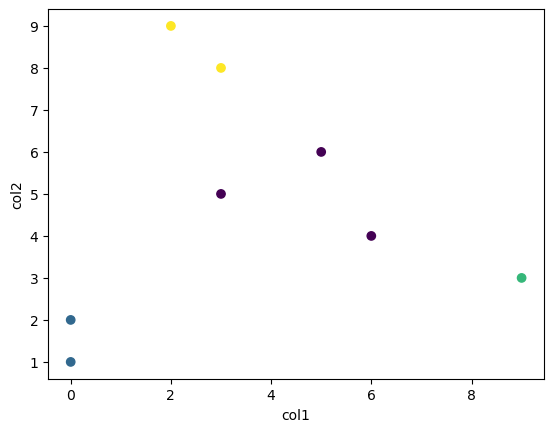

In [13]:
# Parameters
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# DFの準備
df = pd.DataFrame([[0, 1], [0, 2], [3, 5], [2, 9],
                  [3, 8], [5, 6], [6, 4], [9, 3]],
                  columns=['col1', 'col2'])

# クラスタリングを実行
n_cls = 4 # クラスタ数を設定
km = KMeans(n_clusters=n_cls, n_init=10, random_state=7)
cls = km.fit_predict(df)

# DataFrameにクラスタに関する列を挿入
df['cluster_no'] = cls

# Scatterをplot
plt.scatter(df['col1'], df['col2'],
            marker="o", c=df['cluster_no'])

plt.xlabel('col1')
plt.ylabel('col2')
plt.show()

- ##### クラスタ数の見積もり
  - 「Elbow法」が有名
  - 先ほどと同様にエラーは無視してください
  - 一番折れ曲がっているところが妥当なクラスタ数と考えられる

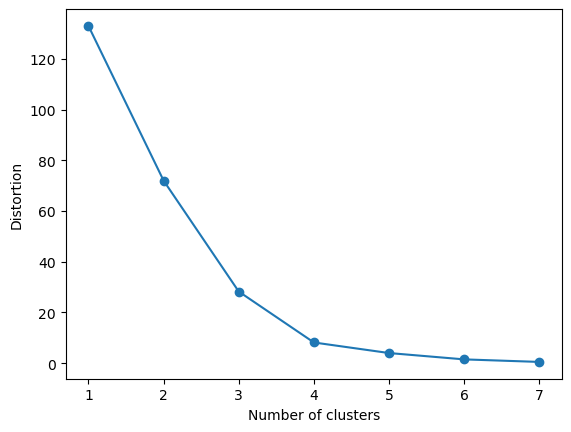

In [14]:
# エルボー法
distortions = []
for i in range(1, 8):
    km = KMeans(n_clusters=i, n_init=10)
    km.fit(df)
    distortions.append(km.inertia_)
plt.plot(range(1, 8), distortions, marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### 相関
##### 相関係数を計算
- df.corr():全列総当たりの相関係数を計算
- df.corrwith(df["列名"])：指定した列に対する相関係数を計算
- df["列名1"].corr(df["列名2"])：列名1と列名2の相関係数を計算
  
##### ヒートマップの描画
- sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="bwr")
  - 第1引数: 相関係数を計算した2次元データ
  - annot: 数値を表示
  - fmt: 数値のformat ".nf"で小数第n位まで、"nd"はn桁の整数
  - cmap: カラーマップ

#####

In [15]:
# 下準備
csv_in = 'data/batting_npb2021.csv'
df1 = pd.read_csv(csv_in, sep=',', skiprows=0, header=0)

,Height,Weight,HomeRun,StrikeOut,Steal
Height,1.000000,0.700030,0.520405,0.425124,-0.235158
Weight,0.700030,1.000000,0.561627,0.261680,-0.484311
HomeRun,0.520405,0.561627,1.000000,0.443375,-0.310043
StrikeOut,0.425124,0.261680,0.443375,1.000000,0.084401
Steal,-0.235158,-0.484311,-0.310043,0.084401,1.000000


0.7000301248513807
Height       0.700030
Weight       1.000000
HomeRun      0.561627
StrikeOut    0.261680
Steal       -0.484311
dtype: float64
0.7000301248513806


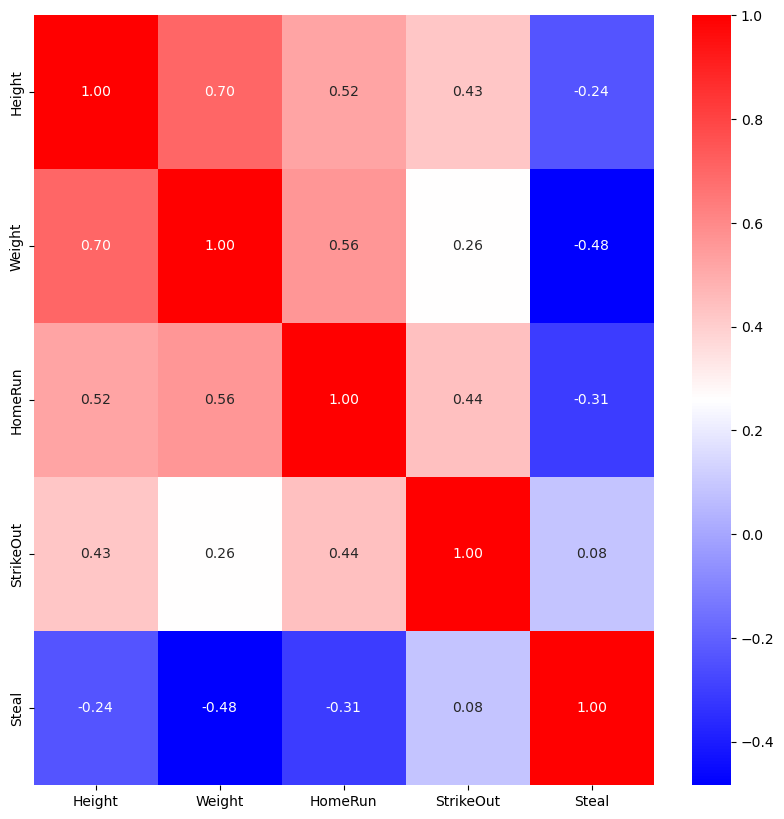

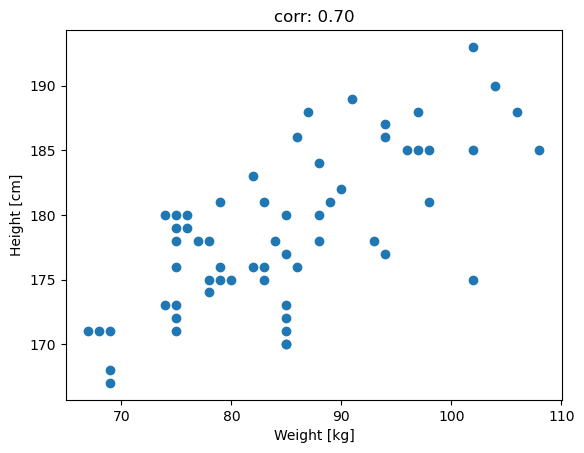

In [16]:
# 全列総当たりの相関係数を計算
df_corr = df1.corr()
display(df_corr)
print(df_corr.at['Weight', 'Height'])

# 指定した列に対する相関係数を計算
print(df1.corrwith(df1['Weight']))

# WeightとHeightの相関係数を計算
print(df1['Weight'].corr(df1['Height']))

## ヒートマップの描画
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='bwr')
plt.show()

## 相関図を描写
plt.scatter(df1['Weight'], df1['Height'])
plt.title('corr: {:.2f}'.format(df_corr.at['Weight', 'Height']))
plt.xlabel('Weight [kg]')
plt.ylabel('Height [cm]')
plt.show()

### 線形単回帰
##### 説明変数と目的変数を分ける。
- X = df[["列名"]] Xは説明変数。2次元データ
- y = df["列名"] yは目的変数。1次元データ

##### 線形単回帰
- sm.OLS(y, X_c): 目的変数, 説明変数の順番でデータを入力し、モデルに変更
- model.fit(): 回帰の計算を実行
- results.summary(): 計算結果を表示
- sm.add_constant(X): 説明変数Xに定数項用の1だけの列を追加

上記を指定したらあとはコピペ

In [17]:
X = df1[ ['Weight'] ] 
y = df1["HomeRun"]
X_c = sm.add_constant(X)

model = sm.OLS(y, X_c)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                HomeRun   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     27.18
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           2.49e-06
Time:                        13:44:03   Log-Likelihood:                -214.81
No. Observations:                  61   AIC:                             433.6
Df Residuals:                      59   BIC:                             437.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.2835      9.003     -3.586      0.0

### 各種係数の表示
- results.rsquared:決定係数 (1に近いほど回帰式がデータに当てはまっていることを表す)
- results.rsquared_adj: 自由度調整済み決定係数
- results.params: 偏回帰係数

In [18]:
print("決定係数: ", results.rsquared)
print("\n自由度調整済み決定係数", results.rsquared_adj)
print("\n偏回帰係数")
print(results.params)

print("\n今回の場合はこのような式が成り立つ　HomeRun = {:.4f} + {:.4f}*Weight".format(results.params["const"], results.params["Weight"]))

決定係数:  0.315425157809346

自由度調整済み決定係数 0.3038221943823858

偏回帰係数
const    -32.283543
Weight     0.550493
dtype: float64

今回の場合はこのような式が成り立つ　HomeRun = -32.2835 + 0.5505*Weight


### 回帰直線の描画

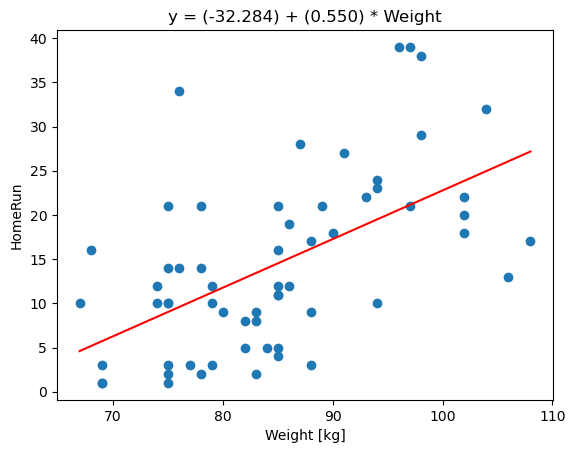

In [19]:
a0 = results.params['const']
a1 = results.params['Weight']
x_min = X['Weight'].min()
x_max = X['Weight'].max()
x_min_max = np.array([x_min, x_max])
y_min_max = a0 + a1 * x_min_max
plt.title('y = ({:.3f}) + ({:.3f}) * Weight'.format(a0, a1))
plt.scatter(X['Weight'], y)
plt.plot(x_min_max, y_min_max, c='red')
plt.xlabel('Weight [kg]')
plt.ylabel('HomeRun')
plt.show()

#### 得られたモデルを用いて、予測を行う

In [20]:
x_test = np.array([ 70.0, 85.0, 100.0 ])
y_test = a0 + a1 * x_test
print(y_test)

[ 6.25096402 14.50835835 22.76575267]


### 線形重回帰分析

In [21]:
# 下準備
csv_in = "data/student-por-gp.csv"
df2 = pd.read_csv(csv_in)
display(df2.head(2))

,age,reason,studytime,failures,schoolsup,higher,goout,health,absences,G3
0,18,course,2 to 5 hours,0,1,1,4,3,4,11
1,17,course,2 to 5 hours,0,0,1,3,3,2,11


In [22]:
X = df2.drop(columns = "G3")
y = df2['G3']

### カテゴリー変数の数値化
カテゴリー変数の場合はreplaceを使用して数値に変更する

In [23]:
print(X["studytime"].value_counts())

X["studytime"] = X["studytime"].replace({"<2 hours": "1", "2 to 5 hours": "2","5 to 10 hours":"3", ">10 hours":"4" }).astype("int")

studytime
2 to 5 hours     206
<2 hours         119
5 to 10 hours     71
>10 hours         27
Name: count, dtype: int64


### ダミー変数化
- pd.get_dummies(X, drop_first, dtype)
  - X: ダミー変数化前のデータフレーム
  - drop_first: trueにすることで、ダミー変数をカテゴリー変数の数-1にできる
  - dtype: データ型の設定をする

In [24]:
X_dumm = pd.get_dummies(X, drop_first=True, dtype="uint8")
print("X_dumm: ", X_dumm.shape)
display(X_dumm.head())

X_dumm:  (423, 11)


,age,studytime,failures,schoolsup,higher,goout,health,absences,reason_home,reason_other,reason_reputation
0,18,2,0,1,1,4,3,4,0,0,0
1,17,2,0,0,1,3,3,2,0,0,0
2,15,2,0,1,1,2,3,6,0,1,0
3,15,3,0,0,1,2,5,0,1,0,0
4,16,2,0,0,1,2,5,0,1,0,0


### 標準化なしで線形重回帰分析

In [25]:
X_dumm_c = sm.add_constant(X_dumm)
model = sm.OLS(y, X_dumm_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     18.82
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           1.53e-30
Time:                        13:44:03   Log-Likelihood:                -921.75
No. Observations:                 423   AIC:                             1868.
Df Residuals:                     411   BIC:                             1916.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.6330      1.71

### 各種係数の表示　(再記)

In [26]:
print("決定係数: ", results.rsquared)
print("\n自由度調整済み決定係数", results.rsquared_adj)
print("\n偏回帰係数")
print(results.params)

決定係数:  0.33500762976006815

自由度調整済み決定係数 0.31720978043491177

偏回帰係数
const                6.632959
age                  0.284534
studytime            0.330960
failures            -1.266708
schoolsup           -1.453179
higher               2.640919
goout               -0.257661
health              -0.191346
absences            -0.060924
reason_home          0.308610
reason_other         0.221979
reason_reputation    0.604262
dtype: float64


### $全説明変数と目的変数を$**標準化して**$線形重回帰分析$

In [27]:
X_scaled_ar = scale(X_dumm)
y_scaled_ar = scale(y)

X_scaled = pd.DataFrame(X_scaled_ar, columns=X_dumm.columns)
y_scaled = pd.Series(y_scaled_ar, name=y.name)

mode = sm.OLS(y_scaled, X_scaled)
results_scaled = mode.fit()

print(results_scaled.summary())

                                 OLS Regression Results                                
Dep. Variable:                     G3   R-squared (uncentered):                   0.335
Model:                            OLS   Adj. R-squared (uncentered):              0.317
Method:                 Least Squares   F-statistic:                              18.87
Date:                Mon, 01 Jul 2024   Prob (F-statistic):                    1.26e-30
Time:                        13:44:03   Log-Likelihood:                         -513.92
No. Observations:                 423   AIC:                                      1050.
Df Residuals:                     412   BIC:                                      1094.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### 標準化偏回帰係数を比較

In [28]:
print(results_scaled.params.sort_values(key=np.abs, ascending=False))

higher               0.266292
failures            -0.266116
schoolsup           -0.187796
age                  0.134906
absences            -0.120470
goout               -0.113137
studytime            0.105909
health              -0.103530
reason_reputation    0.102234
reason_home          0.052357
reason_other         0.020691
dtype: float64


### 得られたモデルを用いて、予測を行う。

In [29]:
X_test = pd.DataFrame([[18, 4, 0, 0, 1, 1, 2, 0, 0, 0, 1], [15, 1, 3, 1, 0, 4, 3, 10, 0, 1, 0]], columns =X_dumm.columns)

print("X for preediction: ")
display(X_test)
X_test_c =sm.add_constant(X_test, has_constant = "add")
y_test = results.predict(X_test_c)
print("予測 y:")
print(y_test)

X for preediction: 


,age,studytime,failures,schoolsup,higher,goout,health,absences,reason_home,reason_other,reason_reputation
0,18,4,0,0,1,1,2,0,0,0,1
1,15,1,3,1,0,4,3,10,0,1,0


予測 y:
0    15.683232
1     3.986678
dtype: float64


### 発展）回帰式の当てはまりの可視化

In [30]:
y_pred = results.predict(X_dumm_c)
print("Predicted y:")
print(y_pred.head())

Predicted y:
0    11.755846
1    13.304000
2    11.517699
3    13.371322
4    13.324895
dtype: float64


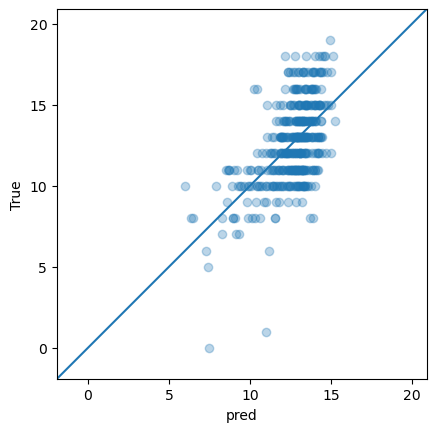

In [31]:
y_min = np.append(y_pred, y).min()
y_max = np.append(y_pred, y).max()

y_margin = (y_max -y_min)*0.1
y_min -= y_margin
y_max += y_margin

plt.scatter(y_pred, y, alpha=0.3)
plt.plot([y_min, y_max], [y_min, y_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.xlabel("pred")
plt.ylabel("True")
plt.show() 

MSE（2乗平均誤差）  
その平方根

In [32]:
mse = mean_squared_error(y, y_pred)
print("mse: ",mse,)
print("RMSE: ",  np.sqrt(mse))

mse:  4.573595787773046
RMSE:  2.138596686561785


### ロジスティクス回帰

In [33]:
df3 = pd.read_csv("data/heart_disease-mid.csv")

### 説明変数と目的変数を分ける

In [34]:
X = df3.loc[:, "BMI":]
y = df3["HeartDisease"]

### ダミー変数化

In [35]:
X_dumm = pd.get_dummies(X, drop_first=True, dtype="uint8")

### 標準化なしでロジスティクス回帰分析

In [36]:
X_dumm_c = sm.add_constant(X_dumm)
model = sm.Logit(y, X_dumm_c)
results = model.fit()
# print(results.summary()) #<-一旦、コメントアウト

Optimization terminated successfully.
         Current function value: 0.488728
         Iterations 6


### 的中率の計算
的中率：モデルとデータの当てはまり度  
accuracy_score(y, y_pred_bin)
- y: 正解の一次データ
- y_pred_bin: 予測の一次データ

In [37]:
y_pred = results.predict(X_dumm_c)
print("予測値 y: ")
print(y_pred.head())

print("予測値のtrue, false判定")
y_pred_bin = (y_pred >= 0.5).astype("int")
print(y_pred_bin.head())

acc = accuracy_score(y, y_pred_bin)
print("的中率: ", acc)

予測値 y: 
0    0.016228
1    0.041271
2    0.263944
3    0.616141
4    0.007364
dtype: float64
予測値のtrue, false判定
0    0
1    0
2    0
3    1
4    0
dtype: int32
的中率:  0.768


### 回帰係数からオッズ比を求める
BMIが1増えると、オッズは、1.035...倍になる
- オッズ = ( 1になる確率　/ 0になる確率 )
- オッズ比 = ( オッズA　/ オッズB )

In [38]:
print("オッズ")
print(np.exp(results.params))

オッズ
const              0.065594
BMI                1.035041
Smoking            1.938841
AlcoholDrinking    0.559827
Stroke             2.784954
AgeCategory        1.379735
GenHealth          0.506740
SleepTime          0.982617
M/F_M              1.862844
dtype: float64


### 標準化あり$でロジスティクス回帰$

In [39]:
X_scaled_ar = scale(X_dumm)
X_scaled = pd.DataFrame(X_scaled_ar, columns=X_dumm.columns)
X_scaled_c = sm.add_constant(X_scaled)

model = sm.Logit(y, X_scaled_c)
results_scaled = model.fit()
# print(results_scaled.summary()) #<-一旦、コメントアウト

Optimization terminated successfully.
         Current function value: 0.488728
         Iterations 6


### 標準化回帰係数を比較

In [40]:
print(results_scaled.params.sort_values(key=np.abs, ascending=False))

AgeCategory        1.092171
GenHealth         -0.766751
Smoking            0.331045
M/F_M              0.310176
Stroke             0.300320
BMI                0.228071
AlcoholDrinking   -0.120897
const             -0.070229
SleepTime         -0.027165
dtype: float64


### 得られたモデルを用いて、予測を行う

In [41]:
X_test = pd.DataFrame([[20.0, 0, 1, 0, 0, 4, 8.0, 0], [70.0, 1, 0, 1, 12, 0, 4.0, 1]], columns=X_dumm.columns)
print("予測値のための説明変数: ")
display(X_test)
X_test_c = sm.add_constant(X_test, has_constant="add")
y_test = results.predict(X_test_c)
print("予測値 y: ")
print(y_test)

予測値のための説明変数: 


,BMI,Smoking,AlcoholDrinking,Stroke,AgeCategory,GenHealth,SleepTime,M/F_M
0,20.0,0,1,0,0,4,8.0,0
1,70.0,1,0,1,12,0,4.0,1


予測値 y: 
0    0.004173
1    0.996944
dtype: float64
